In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from statsmodels.graphics.tsaplots import plot_acf
from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from test_normal import *
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

Datensatz lesen

In [131]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [132]:
# Filtern nach Store
store_number = 33
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

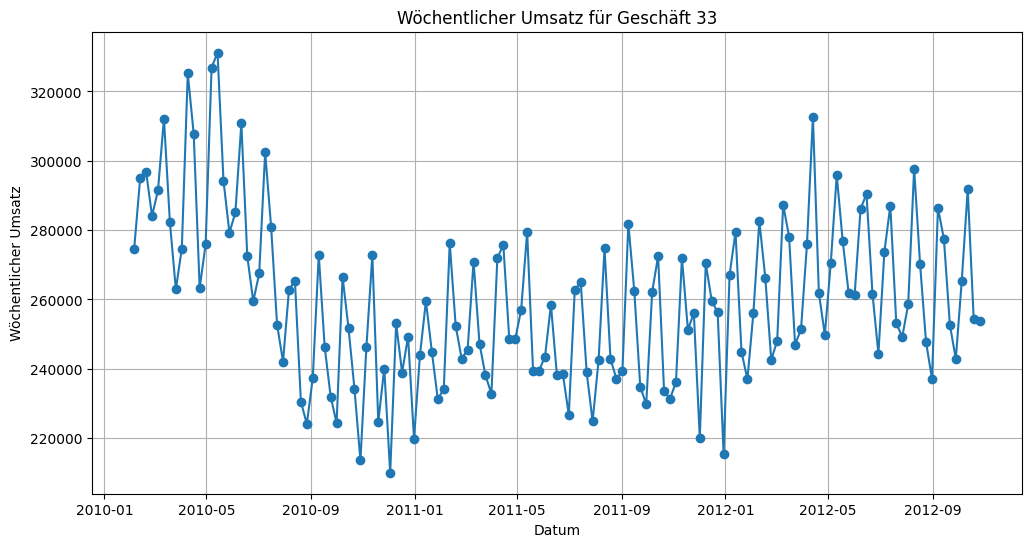

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Wöchentlicher Umsatz für Filialen {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.grid(True)
plt.show()

Seasonal

In [134]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [135]:
#model_type = 'SARIMA'
model_type = 'Naive'

Residuen und Fitted Values berechnen

In [136]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_5.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]
    sarima_model.summary()

Plot

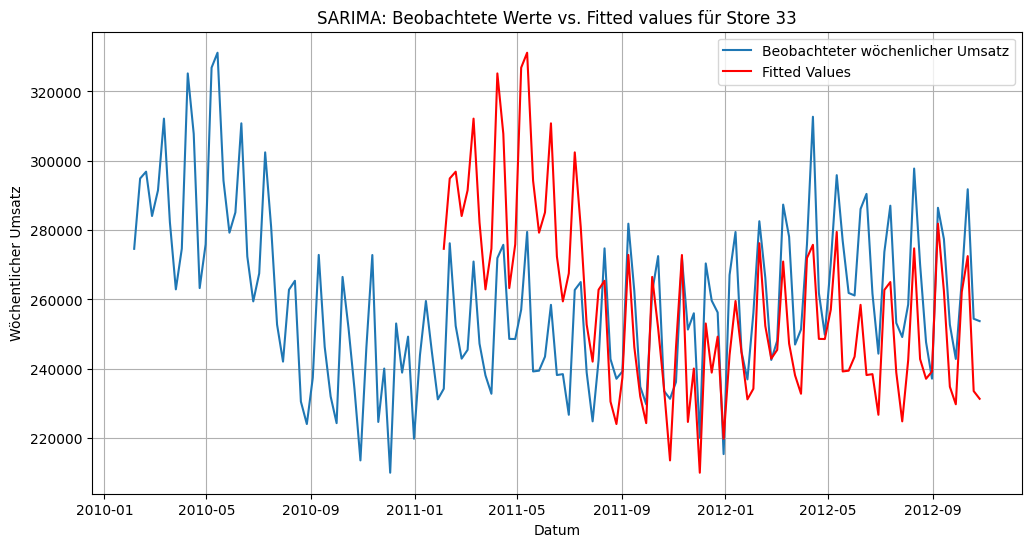

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()


In [138]:
pd.set_option('display.max_rows', None)
non_nan_count = resid.count()
print(non_nan_count)
print(resid)

91
date
2010-02-05         NaN
2010-02-12         NaN
2010-02-19         NaN
2010-02-26         NaN
2010-03-05         NaN
2010-03-12         NaN
2010-03-19         NaN
2010-03-26         NaN
2010-04-02         NaN
2010-04-09         NaN
2010-04-16         NaN
2010-04-23         NaN
2010-04-30         NaN
2010-05-07         NaN
2010-05-14         NaN
2010-05-21         NaN
2010-05-28         NaN
2010-06-04         NaN
2010-06-11         NaN
2010-06-18         NaN
2010-06-25         NaN
2010-07-02         NaN
2010-07-09         NaN
2010-07-16         NaN
2010-07-23         NaN
2010-07-30         NaN
2010-08-06         NaN
2010-08-13         NaN
2010-08-20         NaN
2010-08-27         NaN
2010-09-03         NaN
2010-09-10         NaN
2010-09-17         NaN
2010-09-24         NaN
2010-10-01         NaN
2010-10-08         NaN
2010-10-15         NaN
2010-10-22         NaN
2010-10-29         NaN
2010-11-05         NaN
2010-11-12         NaN
2010-11-19         NaN
2010-11-26         NaN
201

Korrelations Tests

Box Pierce Test: 0.0000
Ljung Box Test: 0.0000
Monti Test: 0.0000
Fisher Test: 0.0000
Fisher Test: 0.0000
Pena Rodriguez (m=29, N=1000): 0.0010
Breusch Godfrey: 0.0000
Run Test: 0.0000
Durbin Watson: 0.3350


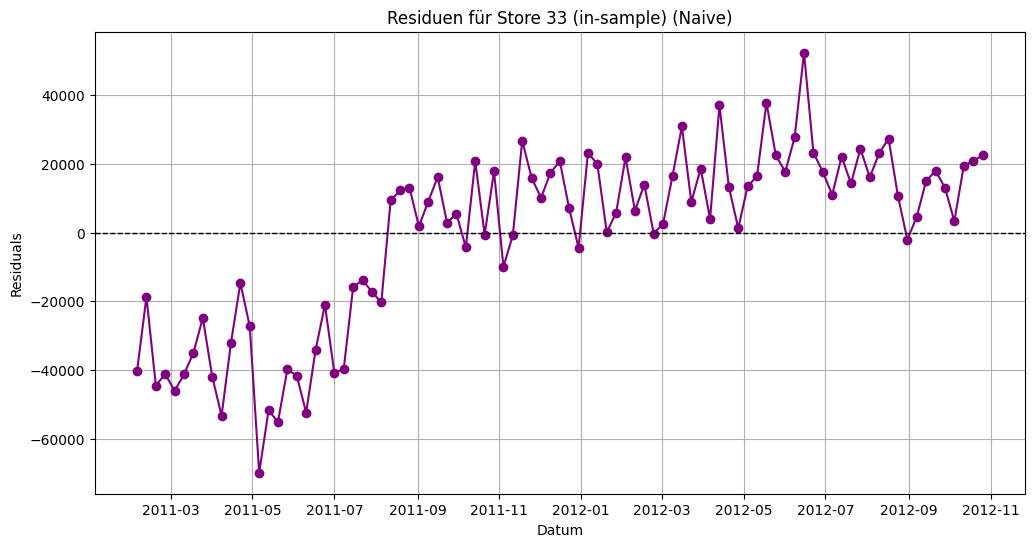

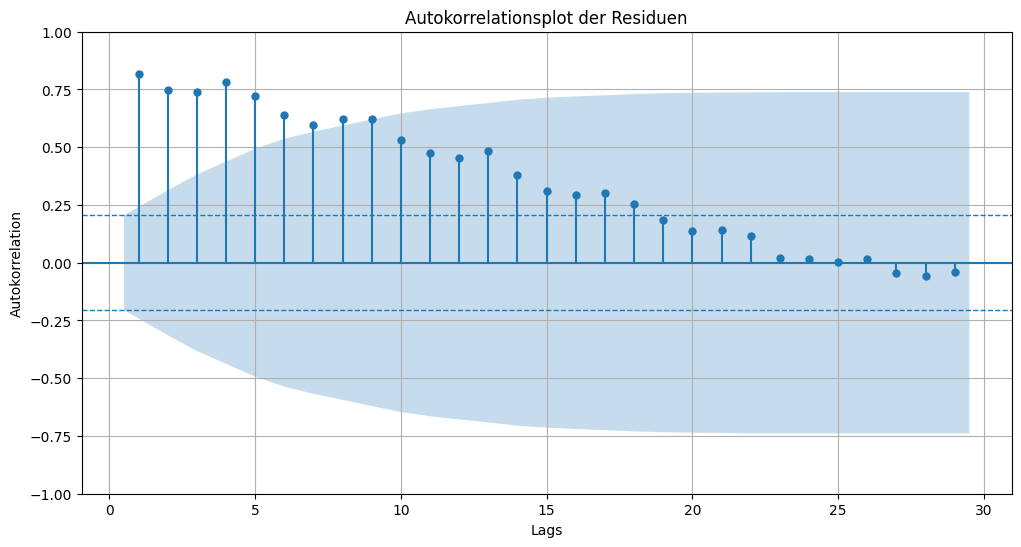

In [139]:
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "acf", m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "pacf", m = 29)
pena_rodriguez_test_mc(residuals = resid)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29)
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)

run_test(residuals = resid)
durbin_watson_test(residuals = resid)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(resid, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (in-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

#ACF Plot
acf_resid_plot(resid, lags = 29)



Mittelwert Tests

Mittelwert der Residuen: -809.8556
T-Test: 0.7674
Wilcoxon Test: 0.5986
Binomial Test: 0.0206
Kolmogorov Test: 0.0363


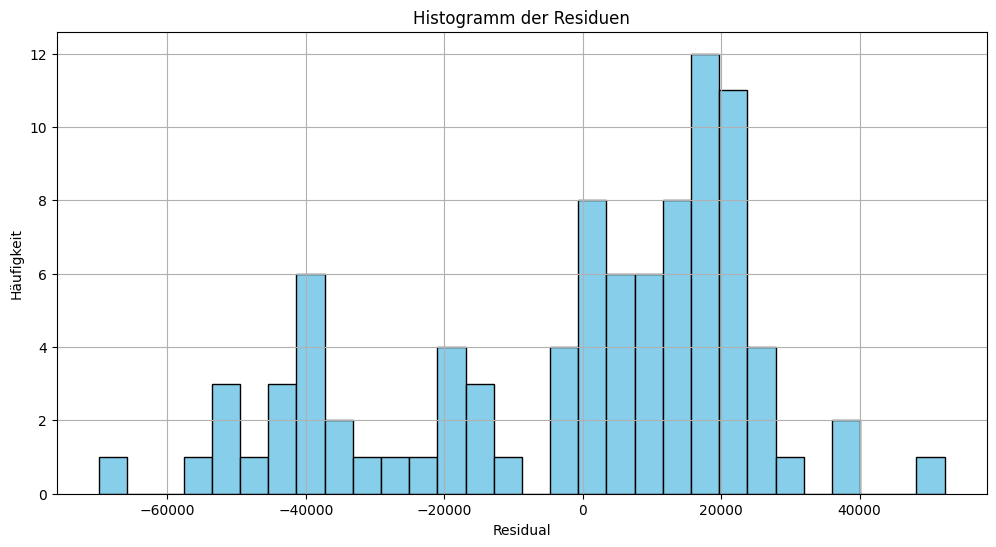

In [140]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)

hist_plot(resid)


SMAPE

In [141]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: nan%


Kreuz Validierung

Seasonal Naive Model Cross-Validation RMSE (period=52): 18477.098784515892


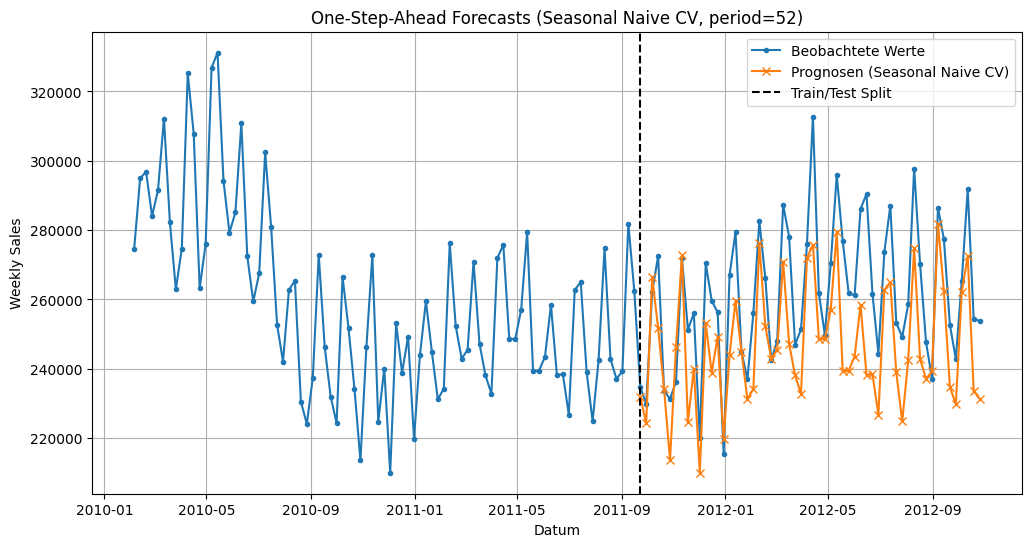

In [142]:
if model_type == 'SARIMA':
    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
if model_type == 'Naive':
    cv_df = cross_validation_naive(sales)


Korrelations Tests

0     2816.28
1     5437.59
2    -4325.06
3    20754.41
4     -632.84
5    17781.64
6    -9967.49
7     -842.90
8    26654.74
9    15951.90
10   10074.10
11   17322.95
12   20763.09
13    6988.39
14   -4445.64
15   23109.26
16   19919.47
17      42.76
18    5764.59
19   21873.29
20    6353.84
21   13951.38
22    -374.51
23    2615.73
24   16424.85
25   30833.26
26    8886.89
27   18558.58
28    3987.24
29   36949.11
30   13233.90
31    1236.89
32   13466.32
33   16374.97
34   37693.69
35   22419.89
36   17654.06
37   27655.37
38   52271.65
39   23232.76
40   17635.95
41   10972.66
42   22030.17
43   14290.84
44   24327.36
45   16076.73
46   23031.64
47   27326.39
48   10576.74
49   -2068.55
50    4586.50
51   15009.96
52   17916.46
53   13081.53
54    3285.77
55   19293.82
56   20869.26
57   22411.17
Name: error, dtype: float64
Box Pierce Test: 0.1891
Ljung Box Test: 0.1064
Monti Test: 0.1269
Fisher Test: 0.7336
Fisher Test: 0.7515
Pena Rodriguez (m=29, N=1000): 0.3986
Breusch Godfrey:

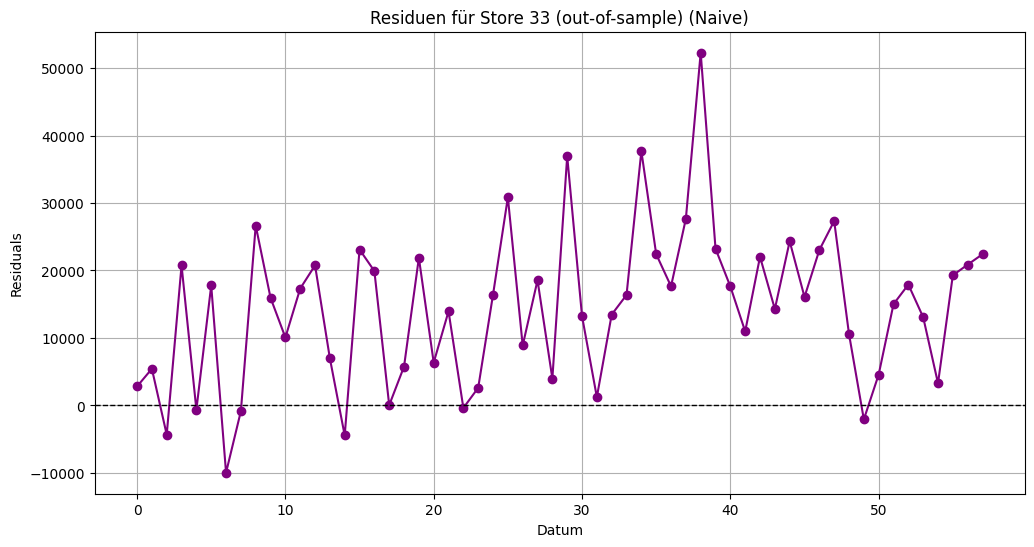

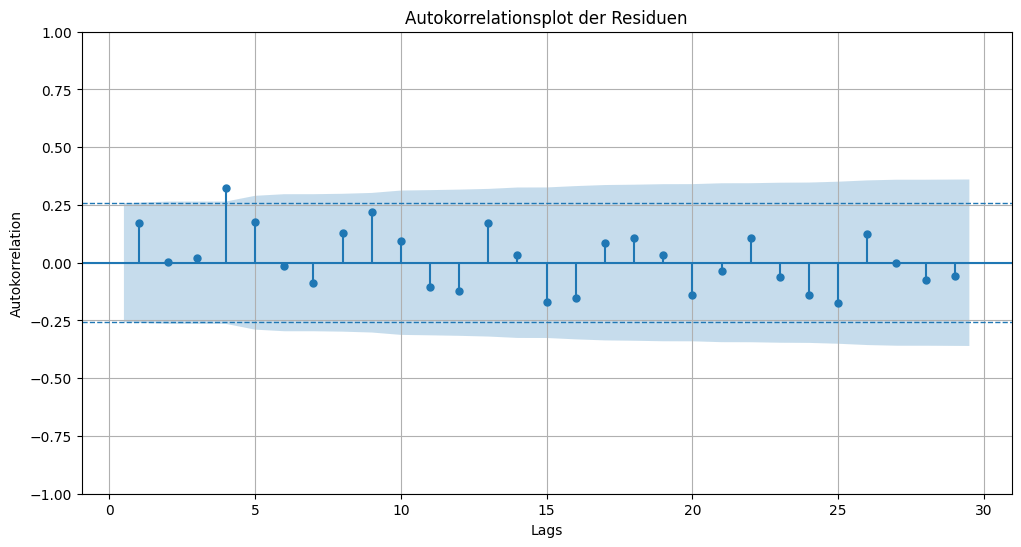

In [143]:
errors = cv_df['error']
print(errors)
box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "acf", m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "pacf", m = 21)
pena_rodriguez_test_mc(residuals = errors)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: Gleich wie in-sample?
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(errors, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (out-of-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


acf_resid_plot(residuals = errors)


Mittelwert Tests

Mittelwert der Errors: 14467.600000000002
T-Test: 0.0000
Wilcoxon Test: 0.0000
Binomial Test: 0.0000
Kolmogorov Test: 0.0000


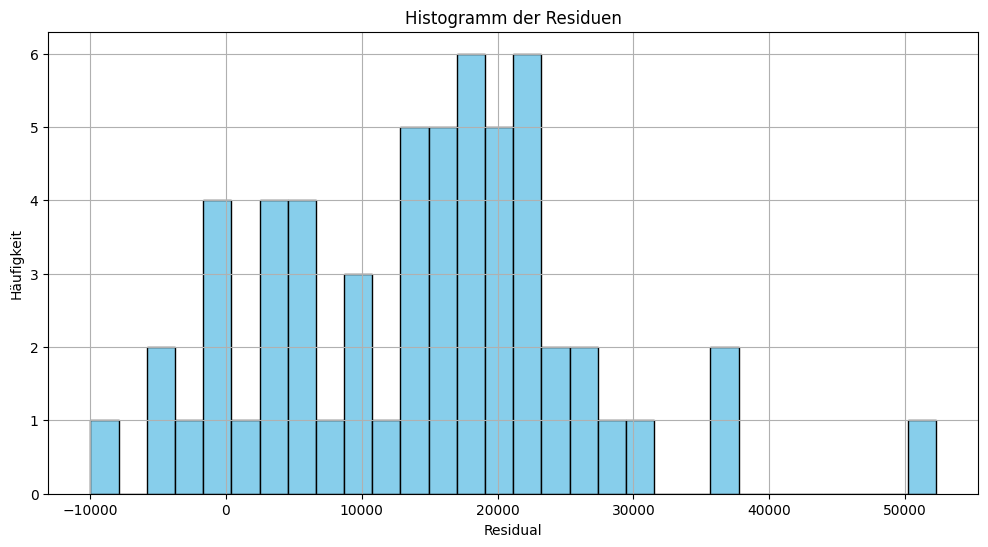

In [144]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)


SMAPE

In [145]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 5.96%
